# 1: Reconstructing Photoacoustic Data

This example code shows how to load some example data and reconstruct it using backprojection. You can then apply spectral unmixing and visualise your data. 

First, we import the required libraries. You can optionally set a default maximum batch size (-1 = run all data in one batch regardless of size) as shown below. 

In [1]:
# Set the maximum batch size (e.g. if you have memory limitations).
import os
os.environ["PAT_MAXIMUM_BATCH_SIZE"] = "-1"

import patato as pat
from patato.data import get_msot_time_series_example
import matplotlib.pyplot as plt
import numpy as np

We then load the example file as an HDF5 format. Alternatively, you can load in IPASC data format or others.

In [2]:
padata = get_msot_time_series_example("so2")[0:1]

We then specify our preprocessor and reconstructor.

In [3]:
nx = 333 # number of pixels
lx = 2.5e-2 # m
pre_processor = pat.MSOTPreProcessor(lp_filter=7e6, hp_filter=5e3) # can specify low pass/high pass/hilbert etc.

reconstructor = pat.Backprojection(field_of_view=(lx, lx, 0), 
                                   n_pixels=(nx, nx, 1)) # z axis must be specified but is empty in this case.
unmixer = pat.SpectralUnmixer(chromophores=["Hb", "HbO2"], 
                              wavelengths = padata.get_wavelengths(), rescaling_factor=4)
so2_calculator = pat.SO2Calculator(nan_invalid=True)

In [4]:
# All processing steps can be called with .run(input, padata, ...)
# They return a dataset, a dictionary and a list of extra data (e.g. so2 and thb could be returned in the list)

filtered_time_series, settings, _ = pre_processor.run(padata.get_time_series(), padata)
# settings here is a dictionary that includes the interpolated detection geometry. It is passed into the next step

reconstruction, _, _ = reconstructor.run(filtered_time_series, padata, padata.get_speed_of_sound(), **settings)

unmixed, _, _ = unmixer.run(reconstruction, None)
so2, _, _ = so2_calculator.run(unmixed, None)

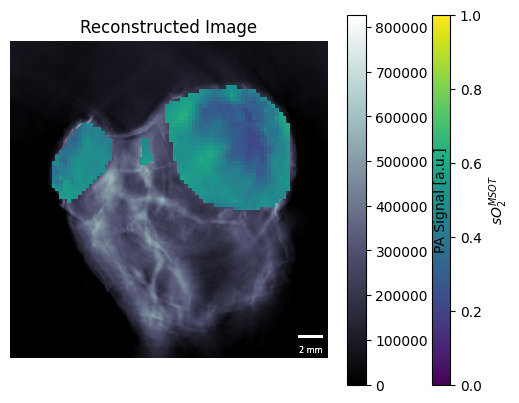

In [5]:
# Overlay the sO2 on top of the reconstructed image:
masks = [padata.get_rois()["tumour_right", "0"], 
         padata.get_rois()["tumour_left", "0"], 
         padata.get_rois()["reference_", "0"]]

im1 = reconstruction.imshow(clim=(0, None))
im = so2.imshow(clim=(0, 1), roi_mask=masks, cmap="viridis")
plt.title("Reconstructed Image")
plt.colorbar(im, label="$sO_2^{MSOT}$")
plt.colorbar(im1, label="PA Signal [a.u.]")
plt.show()